#Lliurament 3. Regressió

Aquesta és la tasca del tercer lliurament de Sistemes d'Aprenentatge Automàtic.

Aplicarem a unes mateixes dades tres mètodes de regressió: regressió lineal simple, regressió robusta amb RANSAC i regressió amb arbres.

Té setze apartats preguntes que puntuen tots igual: $0.625$ punts cadascun.

Preneu com a guia el següent **[quadern de regressió](https://colab.research.google.com/drive/1EBCxdZ-VD_xPzKIbuLg1NSZj74hKWXiw?usp=sharing)**.

##1. Preparació de les dades

a) Carregau el conjunt de dades Boston Housing.

b) Considerau $x$ el nombre de cambres i $y$ el preu de l'habitatge.

c) Representau la gràfica d'$y$ en funció de $x$ sense escalar.

d) Obteniu versions escalades de les variables $x$ i $y$, amb els noms $x\_std$ i $y\_std$.


In [ ]:
import pandas as pd  # doctest: +SKIP
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"

df = pd.read_csv(data_url, sep="\s+", engine='python', skiprows=22, header=None)
print(df.size)

data=np.hstack([df.values[::2,0:11], df.values[1::2,0:3]])

columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PRATIO', 'B', 'LSTAT', 'MEDV']

df=pd.DataFrame(data,columns=columns)

df.head()

11132


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


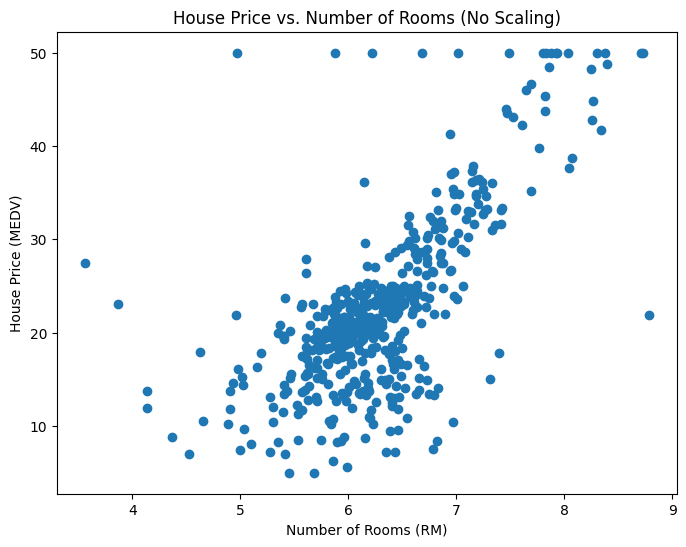

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# b
x = df['RM']
y = df['MEDV']

# c
plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.xlabel('Number of Rooms (RM)')
plt.ylabel('House Price (MEDV)')
plt.title('House Price vs. Number of Rooms (No Scaling)')
plt.show()

# d
scaler = StandardScaler()

x_std = scaler.fit_transform(x.values.reshape(-1, 1))
y_std = scaler.fit_transform(y.values.reshape(-1, 1))

##2. Regressió lineal

a) Ajustau un predictor lineal a les variables d'entrada i sortida escalades.

b) Obteniu el valor de l'entrada escalada $x\_std$ quan $x=6$ cambres.

c) Amb el model de predicció, obteniu el valor de la sortida escalada $y\_std$.

d) Desescalau la sortida per obtenir el preu. Quin és el preu predit per a un habitatge de $6$ cambres? Contrastau el vostre resultat a la gràfica de l'apartat 1c, per confirmar que té sentit.

In [ ]:
# a
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_std, y_std)

# b
x_6 = 6
x_6_std = scaler.transform(np.array([[x_6]]))

# c
y_6_std = model.predict(x_6_std)

# d
y_6 = scaler.inverse_transform(y_6_std)
print(f"El preu predit per a un habitatge de 6 cambres és: {y_6[0][0]}")

El preu predit per a un habitatge de 6 cambres és: 11.036554993633064


##3. RANSAC

Hi ha una sèrie de dades fora del núvol central. Per això és adequat usar un sistema de regressió robusta. Proposau valors del llindar per aconseguir diferents proporcions de punts com a *inliers*.

a) Obteniu tres llindars (*threshold*) diferents, que ajustin la recta a aproximadament una quarta part dels punts, la meitat dels punts i tres quartes parts dels punts.

b) Representau gràficament les tres situacions de l'apartat anterior.

c) Obteniu les tres prediccions del preu de l'habitatge de quatre cambres segons els tres models.

d) Comentau la diferència entre els tres resultats d'aquesta pregunta i comparau-los també amb el resultat de la pregunta anterior. Se semblen bastant les prediccions? Són molt diferents?

Threshold for 25% inliers: 0.13
Threshold for 50% inliers: 0.35
Threshold for 75% inliers: 0.87


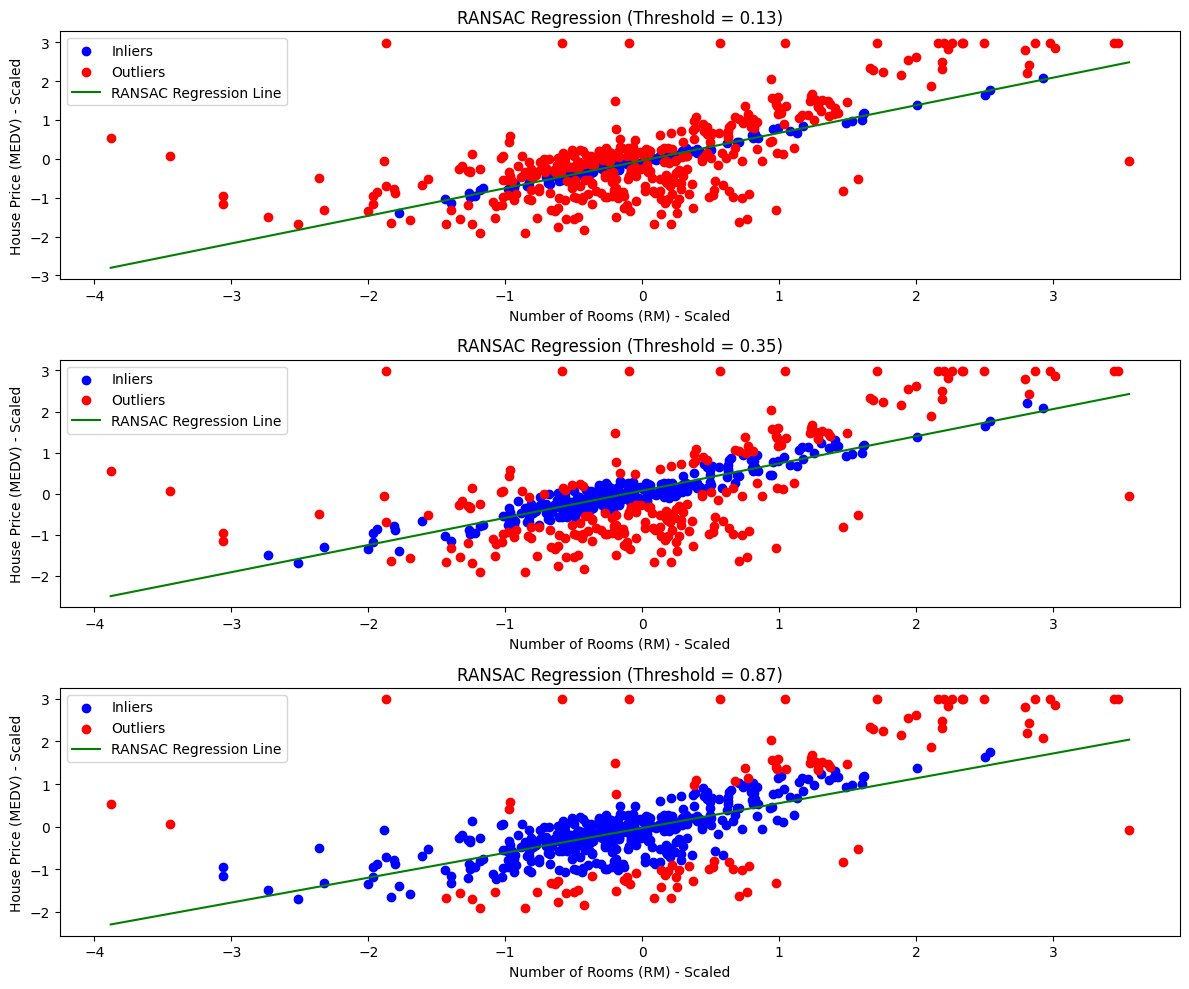

Predicted price for 4 rooms (threshold = 0.13) : 11.21
Predicted price for 4 rooms (threshold = 0.35) : 7.77
Predicted price for 4 rooms (threshold = 0.87) : 11.40


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RANSACRegressor

thresholds = []
inlier_ratios = [0.25, 0.5, 0.75]

for ratio in inlier_ratios:
    ransac = RANSACRegressor(LinearRegression(), residual_threshold=1, max_trials=1000)
    ransac.fit(x_std, y_std)

    threshold = 1
    while True:
        ransac = RANSACRegressor(LinearRegression(), residual_threshold=threshold, max_trials=1000)
        ransac.fit(x_std, y_std)
        inlier_mask = ransac.inlier_mask_
        inlier_ratio = np.sum(inlier_mask) / len(inlier_mask)
        if abs(inlier_ratio - ratio) < 0.05:
            break
        threshold = threshold * (ratio / inlier_ratio) if ratio < inlier_ratio else threshold * (ratio / inlier_ratio)

    thresholds.append(threshold)
    print(f"Threshold for {ratio*100:.0f}% inliers: {threshold:.2f}")

# b

plt.figure(figsize=(12, 10))

for i, threshold in enumerate(thresholds):
    ransac = RANSACRegressor(LinearRegression(), residual_threshold=threshold, max_trials=1000)
    ransac.fit(x_std, y_std)

    line_x = np.linspace(x_std.min(), x_std.max(), 100)
    line_y = ransac.estimator_.predict(line_x.reshape(-1, 1))

    plt.subplot(3, 1, i + 1)
    plt.scatter(x_std[ransac.inlier_mask_], y_std[ransac.inlier_mask_], color='blue', label='Inliers')
    plt.scatter(x_std[~ransac.inlier_mask_], y_std[~ransac.inlier_mask_], color='red', label='Outliers')
    plt.plot(line_x, line_y, color='green', label='RANSAC Regression Line')
    plt.xlabel('Number of Rooms (RM) - Scaled')
    plt.ylabel('House Price (MEDV) - Scaled')
    plt.title(f'RANSAC Regression (Threshold = {threshold:.2f})')
    plt.legend()

plt.tight_layout()
plt.show()

# c
x_4 = 4
x_4_std = scaler.transform(np.array([[x_4]]))

predictions = []
for threshold in thresholds:
    ransac = RANSACRegressor(LinearRegression(), residual_threshold=threshold, max_trials=1000)
    ransac.fit(x_std, y_std)
    y_4_std = ransac.predict(x_4_std)
    y_4 = scaler.inverse_transform(y_4_std)
    predictions.append(y_4[0][0])
    print(f"Predicted price for 4 rooms (threshold = {threshold:.2f}) : {y_4[0][0]:.2f}")


##4. Regressió amb arbres de decisió

a) Ajustau tres arbre de regressió a les mateixes dades que les preguntes anteriors, de forma que obtengueu infraajust, sobreajust i un bon ajust.

b) Representau les tres gràfiques dels models superposades al núvol de punts.

c) Quin és el preu predit per a un habitatge de 6 cambres amb el model de més bon ajust?

d) Comparau aquest resultat amb els dels models lineal simple i RANSAC.

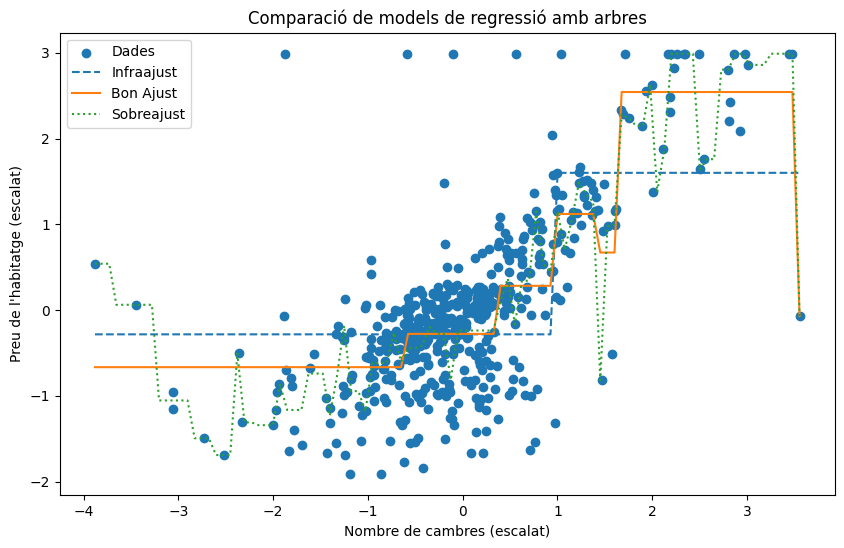

Preu predit per a un habitatge de 6 cambres (bon ajust): 16.42


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# a

model_underfit = DecisionTreeRegressor(max_depth=1)
model_goodfit = DecisionTreeRegressor(max_depth=3)
model_overfit = DecisionTreeRegressor(max_depth=10)

model_underfit.fit(x_std, y_std)
model_goodfit.fit(x_std, y_std)
model_overfit.fit(x_std, y_std)

# b
x_plot = np.linspace(x_std.min(), x_std.max(), 100).reshape(-1,1)

plt.figure(figsize=(10, 6))
plt.scatter(x_std, y_std, label='Dades')
plt.plot(x_plot, model_underfit.predict(x_plot), label='Infraajust', linestyle='--')
plt.plot(x_plot, model_goodfit.predict(x_plot), label='Bon Ajust')
plt.plot(x_plot, model_overfit.predict(x_plot), label='Sobreajust', linestyle=':')


plt.xlabel('Nombre de cambres (escalat)')
plt.ylabel('Preu de l\'habitatge (escalat)')
plt.title('Comparació de models de regressió amb arbres')
plt.legend()
plt.show()

# c
x_6_std = scaler.transform(np.array([[6]]))
y_6_std_pred = model_goodfit.predict(x_6_std)
y_6_std_pred = y_6_std_pred.reshape(-1, 1)
y_6_pred = scaler.inverse_transform(y_6_std_pred)
print(f"Preu predit per a un habitatge de 6 cambres (bon ajust): {y_6_pred[0][0]:.2f}")

Regressió RANSAC
Els tres gràfics mostren la regressió RANSAC amb llindars creixents:
Llindar = 0.13: Molt estricte, la majoria de punts es marquen com a valors atípics (vermell). La línia de regressió no reflecteix bé la tendència de les dades.
Llindar = 0.35: Menys estricte, inclou més valors considerats dins de la tendència (blau) i redueix els valors atípics. La línia de regressió s'ajusta millor.
Llindar = 0.87: Molt relaxat, gairebé tots els punts es classifiquen com a valors vàlids. La línia de regressió segueix de prop la tendència principal, però també inclou soroll.

Regressió Basada en Arbres
Mostra la regressió amb arbres de decisió i compara tres escenaris d'ajust:
subajust: un model senzill en forma de graons que generalitza malament les dades.
Bon Ajust: Un model equilibrat que captura bé la tendència de les dades sense sobreajustar.
Sobreajust: Un model detallat en excés, que s'adapta massa al soroll i als punts específics.

RANSAC: Una regressió lineal que gestiona els valors atípics ajustant llindars.
Arbres: Models no lineals en forma de graons que divideixen les dades segons llindars específics.
Valors atípics:

RANSAC els detecta explícitament (punts vermells).
Els arbres no filtren específicament els valors atípics, però ajusten les divisions per adaptar-se a les dades.
Complexitat de l'Ajust:

RANSAC: Una sola línia de regressió que representa la tendència global de les dades.
Arbres: Models flexibles i constants per trams, capaços de sobreajustar-se al soroll.